In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

import cv2
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines, _straighten_mask, _select_lines,
    group_lines, crop_image_by_points)
from src.utils.playfield_finder import PlayfieldFinder
import matplotlib.pyplot as plt
import numpy as np
from src.utils.intersections import compute_intersections
from src.utils.plotting import display_img

plt.rcParams['image.cmap'] = 'gray'

In [2]:
pic = read_image_as_numpyimage('/home/polymorvic/development/deep-peep-snooker/pics/pic_01_43_02.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png # runda_8/pic_08_08_01.png'
cropped_pic = crop_center(pic)

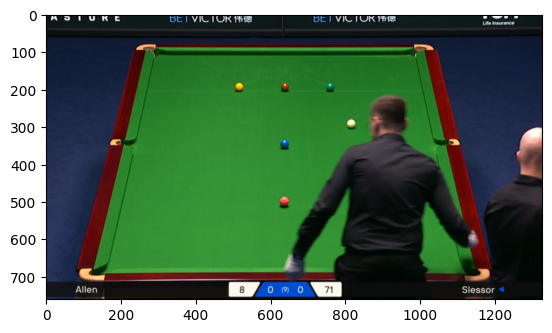

In [3]:
plt.imshow(pic)

In [4]:
finder = PlayfieldFinder(pic)

In [5]:
cushions = finder.find_top_internal_cushion()

In [6]:
# img = cushions['top_left'][0]

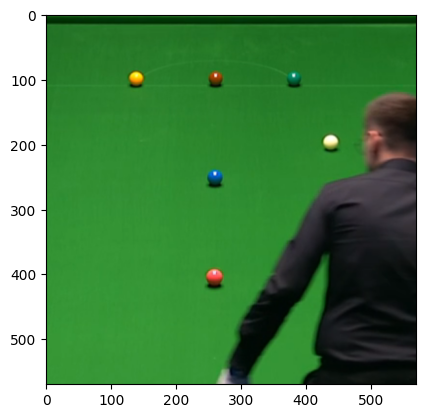

In [7]:
plt.imshow(cropped_pic)

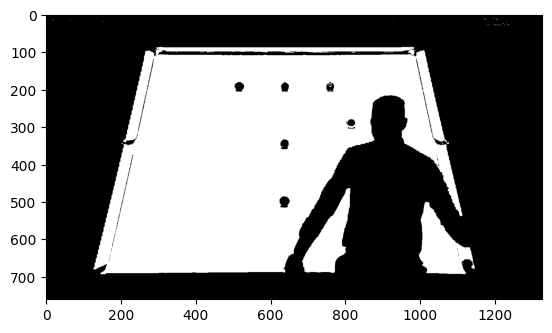

In [8]:
pic_hsv = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
cropped_pic_hsv = cv2.cvtColor(cropped_pic, cv2.COLOR_RGB2HSV)

dominant_color = pipette_color(cropped_pic_hsv)

h, s, v = dominant_color
h_std = np.std(cropped_pic_hsv[:, :, 0])
s_std = np.std(cropped_pic_hsv[:, :, 1])
v_std = np.std(cropped_pic_hsv[:, :, 2])

h_tolerance = int(h_std * 1.5)
s_tolerance = int(s_std * 1.5)
v_tolerance = int(v_std * 1.5)

lower_bound = np.array([max(0, h - h_tolerance), 
                       max(0, s - s_tolerance), 
                       max(0, v - v_tolerance)])

upper_bound = np.array([min(179, h + h_tolerance), 
                       min(255, s + s_tolerance), 
                       min(255, v + v_tolerance)])

binary_mask = cv2.inRange(pic_hsv, lower_bound, upper_bound)

plt.imshow(binary_mask)
plt.show()

In [9]:
inv_binary_img = cv2.bitwise_not(binary_mask)

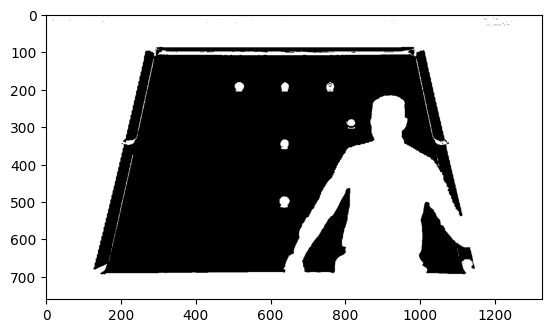

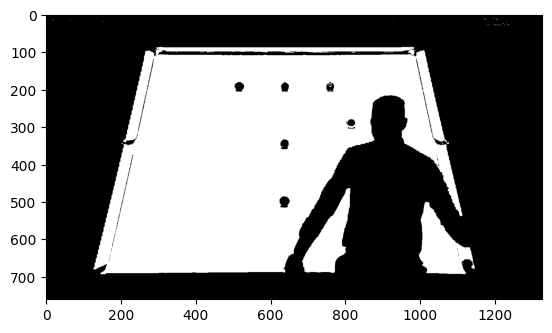

In [10]:
plt.imshow(inv_binary_img)
plt.show()
plt.imshow(binary_mask)

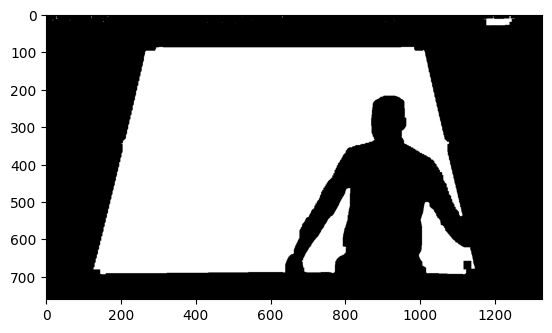

In [11]:
binary_mask_close = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((21, 21), np.uint8))
plt.imshow(binary_mask_close)

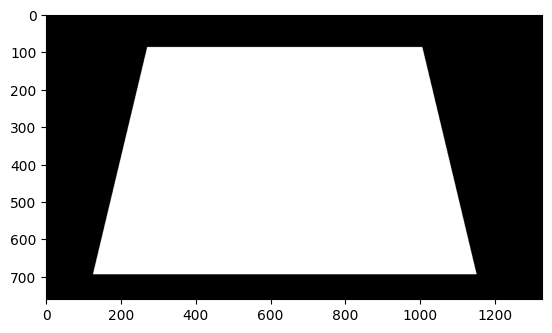

In [12]:
smoothed_binary_mask = _straighten_mask(binary_mask_close)
plt.imshow(smoothed_binary_mask)

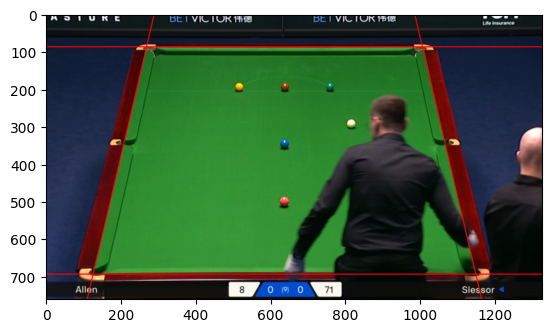

In [13]:
edges = cv2.Canny(smoothed_binary_mask, 150, 200)
segments = cv2.HoughLinesP(
    edges, 
    1, 
    np.pi / 180, 
    threshold=100, 
    minLineLength=100, 
    maxLineGap=10
)

lines = _convert_hough_segments_to_lines(segments)
lines = group_lines(lines, thresh_intercept=100)
lines = _select_lines(lines)
intersections = compute_intersections(lines, binary_mask)

pic_copy = pic.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 2)

plt.imshow(pic_copy)

In [14]:
intersections
intersection_points = np.array([[int(inter.point.x), int(inter.point.y)] for inter in intersections])
intersection_points

array([[ 269,   87],
       [1007,   87],
       [ 126,  694],
       [1150,  694]])

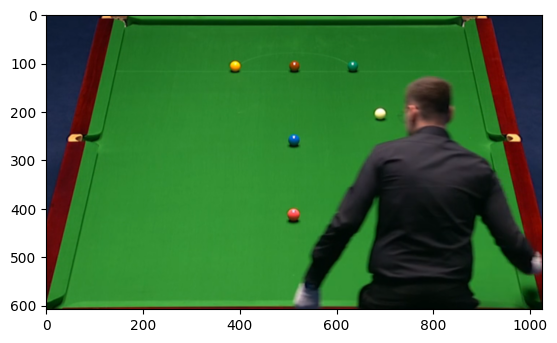

(126, 87)

In [15]:
cropped_by_points, x_start, y_start = crop_image_by_points(pic, intersection_points)
display_img(cropped_by_points)
x_start, y_start 

In [16]:
h, w = cropped_by_points.shape[:2]
roi = cropped_by_points[:int(0.05*h)] 

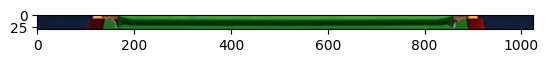

In [17]:
display_img(roi)

In [18]:
hsv_img = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)

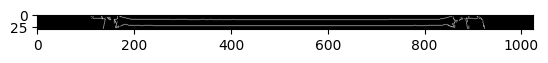

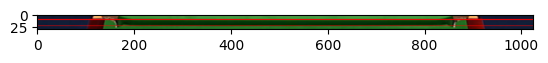

In [19]:
egdes = cv2.Canny(v, 150, 150)
display_img(egdes)
segments = cv2.HoughLinesP(egdes, 1, np.pi/180, 150, 150, 50)
lines = _convert_hough_segments_to_lines(segments)
pic_copy = roi.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 1)
display_img(pic_copy)

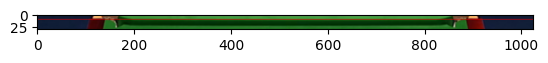

In [22]:
copy_roi = roi.copy()
grouped_lines = group_lines(lines, thresh_intercept=100)
pts = grouped_lines[0].limit_to_img(copy_roi)
cv2.line(copy_roi, *pts, (255, 0, 0), 1)
display_img(copy_roi)


In [21]:
grouped_lines

[LineGroup: y = 0.00 * x + 10.50 (from 4 lines)]